## Circles data 

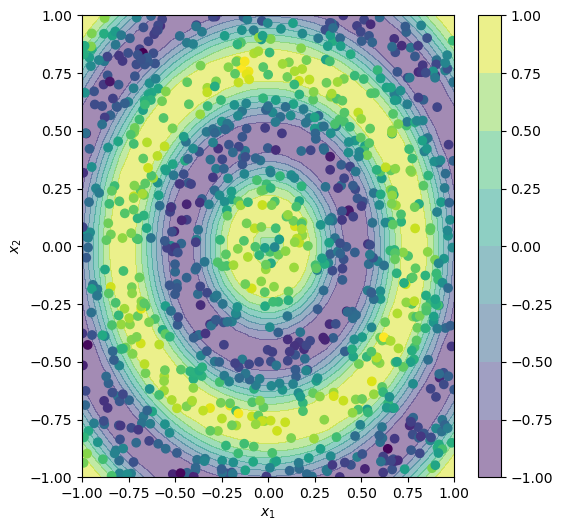

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def circles(X):
    y = np.sin(10*np.sqrt(X[:,0] ** 2 + X[:,1] ** 2))
    return y

def generate_data(y_func,N=1000):
    X = 2*np.random.rand(N,2)-1
    y = y_func(X) + 0.25* np.random.randn(N)
    return X,y

def draw_contours(y_func):
    plt.figure(figsize=(6,6))
    X1,X2 = np.meshgrid(np.linspace(-1, 1, 30),np.linspace(-1, 1, 30))
    Y = y_func(np.c_[X1.ravel(),X2.ravel()]).reshape(X1.shape)
    plt.contourf(X1,X2,Y,alpha=0.5)
    c = plt.colorbar()
    plt.xlabel('$x_{1}$')
    plt.ylabel('$x_{2}$')
    return None

X,y = generate_data(circles)
f = draw_contours(circles)
s = plt.scatter(X[:,0],X[:,1],c=y) 

## Predictions using Keras

/Users/dhammatornriewcharoon/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


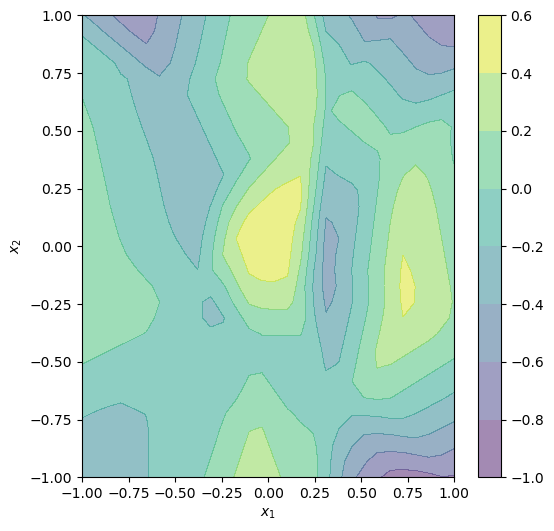

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
model = Sequential()
model.add(Dense(16, input_dim=2, activation='relu'))
model.add(Dense(16, input_dim=2, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X, y, epochs=256, batch_size=64,verbose=False)

f = draw_contours(model.predict)

## Computing predictions from scratch

### Initializing a neural network 

In [4]:
def initialize_network(layers):
    np.random.seed(108)
    # init randomly the weights and biases at 1
    pars = [] # store parameters in a list of dictionaries
    for j in range(1,len(layers)): # loop over layers
        dictionary = {'weight' : np.random.randn(layers[j],layers[j-1]), # weights
                      'bias' : np.random.randn(layers[j],1)} # biases
        pars.append(dictionary)
    return pars

p = X.shape[1] # set number of features
layers = [p,16,16,1] # set number of units in each layer
pars = initialize_network(layers)

In [7]:
print(pars)

[{'weight': array([[-1.02690451,  0.22174943],
       [ 1.13039011,  1.14618522],
       [-0.59273429,  0.11878403],
       [-0.48443021, -1.94491271],
       [ 0.09207734,  0.90216909],
       [ 1.31446859,  0.77110218],
       [-0.54014736, -0.28411518],
       [-0.88933117,  0.40416927],
       [-1.14481162,  0.54539594],
       [ 1.45406998,  1.22397676],
       [ 0.22120243,  1.80664974],
       [ 0.36503864, -0.191469  ],
       [ 0.37726586, -0.16851495],
       [-0.10173043,  1.00489397],
       [ 0.7339729 , -0.09645169],
       [ 1.29032519,  1.59872613]]), 'bias': array([[-1.40539971],
       [ 0.05096249],
       [-0.92656957],
       [-0.00701477],
       [ 0.57593596],
       [ 0.61256419],
       [-0.63081368],
       [-0.4668989 ],
       [-0.29804169],
       [ 1.35058955],
       [ 1.37390176],
       [-0.87389155],
       [ 1.3430511 ],
       [ 1.22263264],
       [ 1.68607929],
       [ 0.44519889]])}, {'weight': array([[ 1.18396712e+00,  1.29063303e+00, -2.7589804

### Forward pass

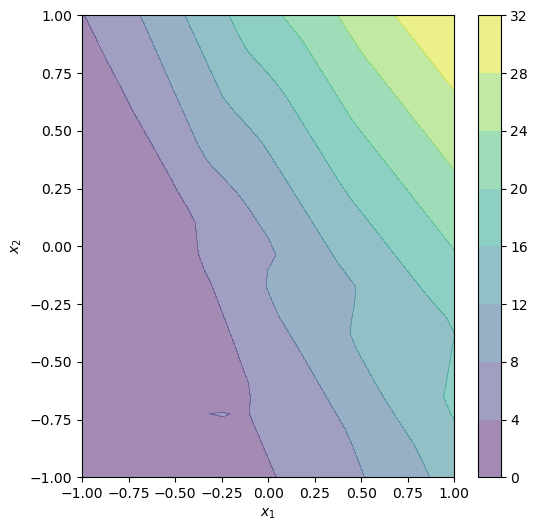

In [11]:
def forward(X,pars):
    
    # make lists to store elements of the graph in memory
    Zs,Hs = [],[]
    
    # initialize inputs
    H = X.T
    
    # loop over layers
    for j in range(len(pars)):
        
        # get parameters for this layer      
        W = pars[j]['weight']
        b = pars[j]['bias']
                
        # activations and output
        Z = np.add(np.matmul(W, H), b) # TODO
        H = Z if j+1 == len(pars) else Z*(Z>0)
         
        # save to list
        Zs.append(Z)
        Hs.append(H)
    
    return Zs,Hs

def predict(X,pars):
    Zs,Hs = forward(X,pars)
    return Hs[-1].flatten()

# test plot using random intialization
f = draw_contours(lambda X: predict(X,pars))

### Backward pass

In [28]:
def backprop(Zs,Hs,X,y,pars,lamda=0):
    
    # setup list for gradients
    grads = []
    
    # data size
    m = X.shape[0]

    # loop over layers
    for j in range(len(pars))[::-1]:
        Z = Zs[j]
        H = Hs[j]
        W = pars[j]['weight']
                
        # get activations gradient
        dZ = (H - y) if j+1 == len(pars) else (Z > 0) * dH
        
        # get input from previous layer
        H_back = Hs[j-1] if j>0 else X.T
                
        # get parameter gradients
        # dW = np.matmul(dZ,np.transpose(H_back)) # TODO
        dW = dZ.dot(H_back.T)
        db = np.sum(dZ,axis=1,keepdims=True)
        
        # save to list
        grads.append({'weight' : dW, 'bias' : db})
        
        # move to next layer
        if j>0: dH = np.matmul(W.T,dZ)
                     
    return grads[::-1]

### Vanilla gradient descent

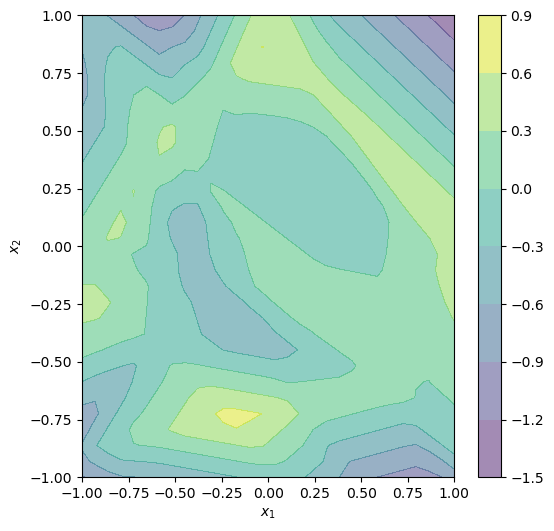

In [29]:
np.random.seed(108)
pars = initialize_network([p,16,16,1])
learning_rate = 1e-5
n_steps = 10000
for i in range(0,n_steps):
    
    # forward and backward pass
    Zs, Hs = forward(X,pars)
    grads = backprop(Zs,Hs,X,y,pars)

    # parameter updates
    for j in range(len(pars)):
        pars[j]['weight'] -= learning_rate * grads[j]['weight']
        pars[j]['bias'] -= learning_rate * grads[j]['bias'] 
        
# plot using optimized parameters 
f = draw_contours(lambda X: predict(X,pars))

### SGD + Adam: TODO (advanced)